In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import seaborn as sns
import re 
from operator import itemgetter
from statannot import add_stat_annotation
import warnings
warnings.filterwarnings('ignore')

## Summary of the functions:

### 1. excelreader:
   - function to open the excel file of the results 
   - imputs : name of the file .xlsx , the gain you want to use (from 50 to 100),  if you want the correction to go back to FITC equivalent type Yes or YES  if you don't want the correction type "NO" 
  
   
### 2. plot_raw_data:
   - function to plot the raw data
   - imputs : the data you want to use (you can call it using the excelreader output) , the number of row for display, the number of columns for display (if the number of conditions is odd you can add one and add a row or a column )
   
### 3. collapse: 
   - function to collapse the triplicate into one column
   - imputs : the data (dataframe) , how you made the triplicate either 'line' 'col' or if you did not do triplicate 'no', the position of the control well with only H2O in this synthax : ['I2','I3','I4']
   
### 4. plot_triplicates
   - function to plot the mean of all the triplicate 
   - imputs : the collapsed dataset, if you want the plots in the same axis or not ("YES" or "NO")

In [2]:
def excelreader(name,gain,correct):
    
    #initialise varibale
    
    time_points = 0 
    time_interval = 0
    
    #open the file 
    
    df_cellfree = pd.ExcelFile(name)
    
    # find the machine name to know where data start 
    
    test = pd.DataFrame(df_cellfree.parse(0))

    if re.search('Synergy',str(test.iloc[7,1])) == None :
        
        s = 64
        
        correction = [3720.7,39499,47364,192405]

    else: 
        s = 67
        
        correction = [5929.3,57884,73091,283567]
        
        
        
    #find the number of time points
    
    if s == 67:
        
        time_points = int(re.findall(r'\d+',test.iloc[17,1])[-1])
        time_interval = int(re.findall(r'\d+',test.iloc[17,1])[-3])

    else : 
        
        time_points = int(re.findall(r'\d+',test.iloc[16,1])[-1])
        time_interval = int(re.findall(r'\d+',test.iloc[16,1])[-3])
        
    # "crop" the table depending on the gain set 
    
    if gain == 50 :
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+12+(3*time_points):s+13+(4*time_points)])
        c = correction[0]
    elif gain == 70 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+8+(2*time_points):s+9+(3*time_points)])
        c = correction[1]
    elif gain == 75 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s+4+time_points:s+5+(2*time_points)])
        c = correction[2]
    elif gain == 100 : 
        df_Fcellfree = pd.DataFrame(df_cellfree.parse(0).values[s:s+1+time_points])
        c = correction[3]

    # Label first row as  column names
    df_Fcellfree.columns = df_Fcellfree.iloc[0]
    

    # Drop the first row (Which is column names)
    df_Fcellfree = df_Fcellfree.iloc[1: , :]
    
    
    # Drop the First Column ---> Generates "NAN column"
    df_Fcellfree = df_Fcellfree.iloc[: , 1:]
    
    
    remove = np.asarray(df_Fcellfree.columns)
    
    
    df_Fvalues = df_Fcellfree.reset_index().drop([remove[0],remove[1],'index'],axis = 1).astype('float64')
    
    
    if correct == "NO":
        df_Fvalues = df_Fvalues  
    else:
        df_Fvalues = df_Fvalues/c # the calibration to go back to µM 
    
    time_list = [0]
    n_rows = df_Fvalues.shape[0]
    time = 0
    
    #create a column with the time
    
    for i in range(n_rows):
        time += time_interval
        time_list.append(time)

    df_Tvalues = pd.DataFrame([time_list]).transpose().rename(columns={0:'Time'})
    
    df_Fvalues['Time'] = df_Tvalues['Time']
    
    #return the final table
    
    return (df_Fvalues)

In [3]:
def plot_raw_data(data,nr,nc):
    fig,axs = plt.subplots(nr, nc, sharex = True, sharey = True,figsize=(30, 30))
    counter = 0
    for i in range(nr):
        for j in range(nc):
            axs[i,j].plot(data['Time'],data[data.columns[counter]])
            counter+=1
    plt.show()

In [4]:
def collapse(data,tripl,control):
    
    #create a variable with names of the columns
    
    col=[]
    name =[]
    
    for ch in data.columns[:-1]:
        col.append(ch)

    #if the imput is line then the triplicate are a list of the column name 3 by 3 
    
    if tripl == 'line': 

        i = 0
        j = 0
        while i < round((len(col)/3),0):
            name.append([col[j],col[j+1],col[j+2]])
            i= i +1
            j = j+3 
            
    elif tripl == 'col':
        
        #create a list of the repeating letters
        duplicates = []
        for char in re.findall('[a-zA-Z]',str(col)):
            ## checking whether the character have a duplicate or not
            ## str.count(char) returns the frequency of a char in the str
            if str(col).count(char) > 1:
                []
            ## appending to the list if it's already not present

            if char not in duplicates :

                duplicates.append(char)
        
        #create a list of the repeated number
        b = list(np.array_split(re.findall(r'\d+ ?',str(col)),len(duplicates))[0])

        #for each repeating number add the repeating letter 

        li = []

        for i in b :
            for j in duplicates :
                li.append(j+str(i))


        #create a list of list containing 3 by 3 the name of the previous list

        i = 0 
        j = 0
        name=[]
        
              
        while i < len(li)/3:
            name.append([li[j],li[j+1],li[j+2]])
            i= i +1
            j = j+3  

    else : 
        name = col
        
    pos = []
    collapse = name
    
    list_bg = control
    
    df_Fbg = data[list_bg]
    df_Fbg['mean'] = df_Fbg.mean(axis=1)
    
    for col,i in zip(collapse,range(len(collapse))):

        list_flu = collapse
        df_flu = data[col]
        df_flu['mean'] = df_flu.mean(axis=1)
        df_flu['cor'] = df_flu['mean']-df_Fbg['mean']

        # Build the Backgruond Table...
        # TIME
        df_flut = data['Time']

        # MEAN
        df_flut['mean'] = df_flu['mean']
        df_flut['cor'] = df_flu['cor']

        #df_flut.head()

        data[str(col)] = df_flut['cor']
    
    for i in range(len(name)):
        pos.append(str(name[i]))
    
    df_Fcollapse = data[pos]
    df_Fcollapse['Time'] = data['Time']
    
    df_Fcollapse[df_Fcollapse<0]=0
    
    return (df_Fcollapse)

In [5]:
def plot_triplicates(data,sa):
    std = []
    for i in data.columns.values[:-1]:
        std.append(statistics.stdev(data[i]))

    if sa == "NO":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
    elif sa =="YES":
        for col,i in zip(data.columns,range(len(data.columns.values)-1)):
            plt.errorbar(data['Time'],data[col],yerr=std[i],label=data.columns.values[:-1][i])
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [6]:
def main(data,gain,cor,nr,nc,tripl,control,sa):
    
    file = excelreader(data,gain,cor)
    
    #plot_raw_data(file,nr,nc)
    
    fileC = collapse(file,tripl,control)
        
    #plot_triplicates(fileC,sa)
    
    return fileC

# test

df_init = main('11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

df_init.head()

,"['B15', 'C15', 'D15']","['E15', 'F15', 'G15']","['B16', 'C16', 'D16']","['E16', 'F16', 'G16']","['B17', 'C17', 'D17']","['E17', 'F17', 'G17']","['B18', 'C18', 'D18']","['E18', 'F18', 'G18']","['B19', 'C19', 'D19']","['E19', 'F19', 'G19']","['B20', 'C20', 'D20']","['E20', 'F20', 'G20']","['B21', 'C21', 'D21']","['E21', 'F21', 'G21']","['B22', 'C22', 'D22']","['E22', 'F22', 'G22']",Time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000292,0.000000,0.000000,0.000105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,0.000369,0.000196,0.000251,0.000205,0.000502,0.000625,0.000301,0.000000,0.000383,0.000014,0.000315,0.000246,0.000000,0.000036,0.000000,0.0,5
2,0.000474,0.000000,0.000315,0.000219,0.000616,0.000379,0.000351,0.000000,0.000702,0.000000,0.000556,0.000073,0.000014,0.000036,0.000205,0.0,10
3,0.001104,0.000233,0.001090,0.000438,0.001172,0.000169,0.000848,0.000091,0.001113,0.000141,0.000949,0.000000,0.000825,0.000369,0.000643,0.0,15
4,0.001391,0.000246,0.001450,0.000347,0.001240,0.000337,0.000953,0.000962,0.001546,0.000985,0.000725,0.000046,0.001897,0.002007,0.000702,0.0,20


# Plot the integrases

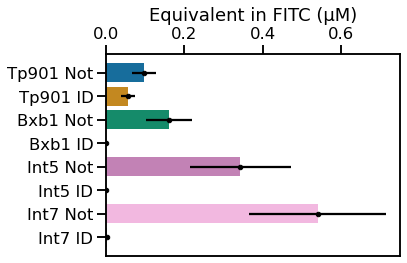

In [25]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

df_init = main('11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

intcol = ["['B20', 'C20', 'D20']","['B21', 'C21', 'D21']","['B22', 'C22', 'D22']","['B15', 'C15', 'D15']","['B16', 'C16', 'D16']", "['B17', 'C17', 'D17']","['B18', 'C18', 'D18']","['B19', 'C19', 'D19']"]
intcol.sort()
name = ["Tp901 Not","Tp901 ID","Bxb1 Not","Bxb1 ID","Int5 Not","Int5 ID","Int7 Not","Int7 ID"]

ints = pd.DataFrame()
std = []
for i in range(len(intcol)):
    ints[name[i]] = df_init[intcol[i]]
for j in ints.columns:
    std.append(statistics.stdev(ints[j]))   


sns.set_context("talk") 

sns.barplot(x=ints.values[-1],y=ints.columns.values,palette='colorblind')
plt.errorbar(ints.values[-1], ints.columns.values, xerr=std,ecolor='black',fmt='.k')
plt.xlabel("")
plt.title("Equivalent in FITC (µM)")
plt.tight_layout()
#plt.savefig('plots/Simple Integrases.png',dpi=300)
plt.show()

# Plot NAND/AND 

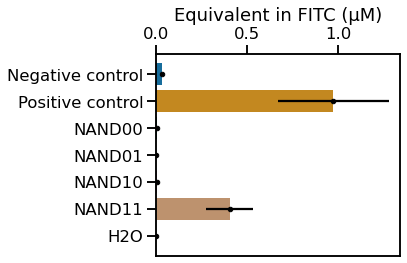

In [26]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


df_init = main('andnotCF.xlsx',75,"YES",3,8,'col',['I12', 'J12', 'K12'],"YES")


name = ["Negative control","Positive control","AND00","AND01","AND10","AND11","NAND00","NAND01","NAND10","NAND11","H2O"]

nand = pd.DataFrame()
std = []
#print(df_init.columns.values)

AND= [0,1,2,3,4,5,10]
NAND= [0,1,6,7,8,9,10]
for i in NAND:#len(df_init.columns.values)-1):
    nand[name[i]] = df_init[df_init.columns[i]]
for j in nand.columns:
    std.append(statistics.stdev(nand[j]))   

sns.set_context("talk") 

sns.barplot(x=nand.values[-1],y=nand.columns.values,palette='colorblind')
plt.errorbar(nand.values[-1], nand.columns.values, xerr=std,ecolor='black',fmt='.k')
plt.xlabel("")
plt.title("Equivalent in FITC (µM)")
plt.tight_layout()
#plt.savefig('plots/NAND.png',dpi=300)
plt.show()



# Plot 3 ipmputs

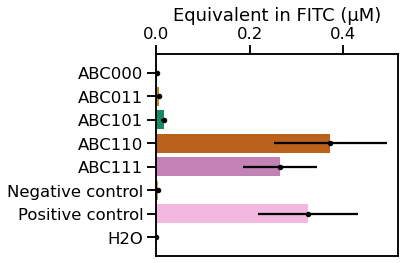

In [27]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


df_init = main('11.03.22 cell free.xlsx',75,"YES",3,8,'col',['E22', 'F22', 'G22'],"YES")

imput_3_col = ["['E20', 'F20', 'G20']","['E21', 'F21', 'G21']","['E22', 'F22', 'G22']","['E15', 'F15', 'G15']","['E16', 'F16', 'G16']", "['E17', 'F17', 'G17']","['E18', 'F18', 'G18']","['E19', 'F19', 'G19']"]
imput_3_col.sort()

name = ["ABC000","ABC011","ABC101","ABC110","ABC111","Negative control","Positive control","H2O"]

imputs_3 = pd.DataFrame()
std = []

for i in range(len(imput_3_col)):
    imputs_3[name[i]] = df_init[imput_3_col[i]]
    
    
for j in imputs_3.columns:
    std.append(statistics.stdev(imputs_3[j]))   


sns.set_context("talk") 

sns.barplot(x=imputs_3.values[-1],y=imputs_3.columns.values,palette='colorblind')
plt.errorbar(imputs_3.values[-1], imputs_3.columns.values, xerr=std,ecolor='black',fmt='.k')
plt.xlabel("")
plt.title("Equivalent in FITC (µM)")
plt.tight_layout()
#plt.savefig('plots/3_imputs_corrected.png',dpi=300)
plt.show()


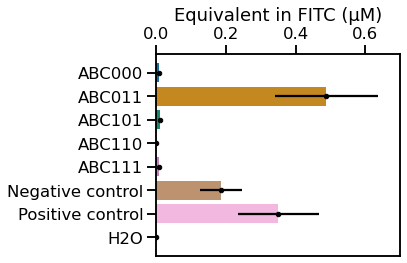

In [51]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


df_init = main('18.02.22 cell free.xlsx',75,"YES",6,8,'col',['B22', 'C22', 'D22'],"YES")

#imput_3_col = ["['E20', 'F20', 'G20']","['E21', 'F21', 'G21']","['E22', 'F22', 'G22']","['E15', 'F15', 'G15']","['E16', 'F16', 'G16']", "['E17', 'F17', 'G17']","['E18', 'F18', 'G18']","['E19', 'F19', 'G19']"]
#imput_3_col.sort()

name = ["ABC000","ABC011","ABC101","ABC110","ABC111","Negative control","Positive control","H2O"]

imputs_3 = pd.DataFrame()
std = []



for i in range(len(df_init.columns)-1):
    imputs_3[name[i]] = df_init[df_init.columns[i]]
    
    
for j in imputs_3.columns:
    std.append(statistics.stdev(imputs_3[j]))   


sns.set_context("talk") 

sns.barplot(x=imputs_3.values[-1],y=imputs_3.columns.values,palette='colorblind')
plt.errorbar(imputs_3.values[-1], imputs_3.columns.values, xerr=std,ecolor='black',fmt='.k')
plt.xlabel("")
plt.title("Equivalent in FITC (µM)")
plt.xlim(0,0.7)
plt.tight_layout()
plt.savefig('plots/3_imputs_bad.png',dpi=300)
plt.show()



# Plot the integrases cyto cell free in one plot

                  0  Cellfree         Cyto   errorcf      errorcy
Tp901 Not  0.097230  0.097230  31370.28500  0.029816  1388.204905
Tp901 ID   0.057102  0.057102  16232.09600  0.018257  3746.021900
Bxb1 Not   0.161164  0.161164  63220.47700  0.059150    35.910739
Bxb1 ID    0.000465  0.000465    373.34436  0.000320    93.097043
Int5 Not   0.343622  0.343622  58798.44500  0.128747   825.566551
Int5 ID    0.000999  0.000999    162.51492  0.000357    42.768618
Int7 Not   0.541348  0.541348  53784.26000  0.174976  1079.427837
Int7 ID    0.001546  0.001546    149.13892  0.000562   397.409736


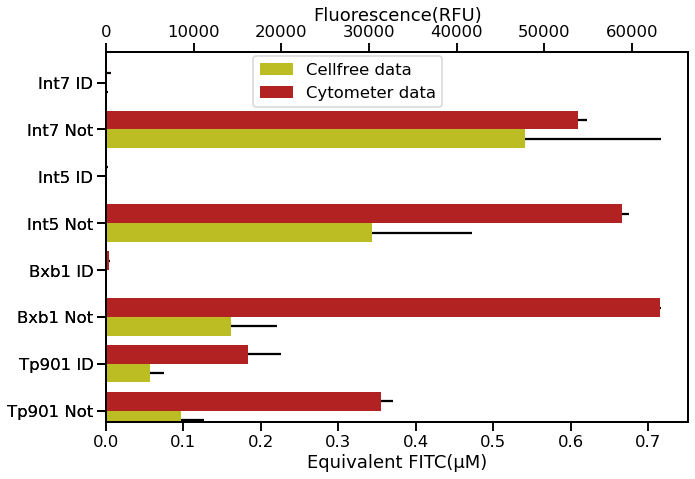

In [28]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

df_init = main('11.03.22 cell free.xlsx',75,"YES",6,8,'col',['E22', 'F22', 'G22'],"YES")

intcol = ["['B20', 'C20', 'D20']","['B21', 'C21', 'D21']","['B22', 'C22', 'D22']","['B15', 'C15', 'D15']","['B16', 'C16', 'D16']", "['B17', 'C17', 'D17']","['B18', 'C18', 'D18']","['B19', 'C19', 'D19']"]
intcol.sort()
name = ["Tp901 Not","Tp901 ID","Bxb1 Not","Bxb1 ID","Int5 Not","Int5 ID","Int7 Not","Int7 ID"]

ints = pd.DataFrame()
std = []
for i in range(len(intcol)):
    ints[name[i]] = df_init[intcol[i]]
for j in ints.columns:
    std.append(statistics.stdev(ints[j]))   

df['Cellfree']= pd.DataFrame(data = ints.values[-1],index=ints.columns.values)
df['Cyto']= [31370.285,
 16232.096,
 63220.477,
 373.34436,
 58798.445,
 162.51492,
 53784.26,
 149.13892]
df['errorcf']= std
df['errorcy'] = [1388.2049049568443,
 3746.0218996708545,
 35.910738728023155,
 93.09704303406816,
 825.5665514371234,
 42.7686181104472,
 1079.4278365761586,
 397.4097360874957]

print(df)

fig = plt.figure()
# Create matplotlib figure

fig.set_size_inches(10, 7)

ax = fig.add_subplot(111)
ax2 = ax.twiny()

sns.set_context("talk")

df.Cellfree.plot(kind='barh', color="tab:olive",ax=ax, width=0.4, position=1,label="Cellfree data",xerr=[np.zeros(len(df.errorcf)),df.errorcf.values])
df.Cyto.plot(kind='barh', color="firebrick", ax=ax2, width=0.4, position=0,label="Cytometer data",xerr=[np.zeros(len(df.errorcy)),df.errorcy.values])
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0.88))
ax.set_xlabel("Equivalent FITC(µM)")
ax2.set_xlabel("Fluorescence(RFU)")
plt.tight_layout()
#plt.savefig('plots/comp_cyto_cf.png',dpi=300)
plt.show()

In [52]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

df= pd.DataFrame(data = ints.values[-1],index=ints.columns.values)


df[1]= prod_integrases
df = df.rename(columns={df.columns[0]:"data",df.columns[1]:"model"})
print(df.head())

fig = plt.figure()
# Create matplotlib figure

fig.set_size_inches(10, 5)

ax = fig.add_subplot(111)
ax2 = ax.twinx()

sns.set_context("talk")

df.data.plot(kind='bar', color="tab:olive",ax=ax, width=0.4, position=1,label="Experimental data")
df.model.plot(kind='bar', color="firebrick", ax=ax2, width=0.4, position=0,label="Fitted translation rate")
fig.legend(loc='upper center', bbox_to_anchor=(0.4,0.95))
ax.set_ylabel("Equivalent FITC(µM)")
ax2.set_ylabel("Production rate(µM*min-1)")
plt.tight_layout()
#plt.savefig('plots/comp_fit_exp.png',dpi=300)
plt.show()


'\ndf[1]= prod_integrases\ndf = df.rename(columns={df.columns[0]:"data",df.columns[1]:"model"})\nprint(df.head())\n\nfig = plt.figure()\n# Create matplotlib figure\n\nfig.set_size_inches(10, 5)\n\nax = fig.add_subplot(111)\nax2 = ax.twinx()\n\nsns.set_context("talk")\n\ndf.data.plot(kind=\'bar\', color="tab:olive",ax=ax, width=0.4, position=1,label="Experimental data")\ndf.model.plot(kind=\'bar\', color="firebrick", ax=ax2, width=0.4, position=0,label="Fitted translation rate")\nfig.legend(loc=\'upper center\', bbox_to_anchor=(0.4,0.95))\nax.set_ylabel("Equivalent FITC(µM)")\nax2.set_ylabel("Production rate(µM*min-1)")\nplt.tight_layout()\n#plt.savefig(\'plots/comp_fit_exp.png\',dpi=300)\nplt.show()\n'